# Stream stage data curation
This notebook describes setting up of stream stage data for use with OLPROC.

## Background
Head and stage data have been sampled simultaneously in five different locations (sites) at the Hagfors PCE contaminated aquifer.

## Aim and purpose
The purpose of this notebook is to curate raw stage data for use with OLPROC. This notebook must be run before the notebook that curates `head-stage differences`.

Essential imports:

In [1]:
import os
import numpy as np
import pandas as pd
import pyemu
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data_dir = os.path.join('..', '..', 'data', 'raw_data', 'stage')
assert(data_dir)

In [3]:
os.listdir(data_dir)

['NI15-O1-STG.csv',
 'NI15-O44-STG.csv',
 'NI15-O46-STG.csv',
 'NI15-O47-STG.csv',
 'NI15-O48-STG.csv',
 'readme.md']

Load up the raw data:

In [4]:
stage_data = {}

In [5]:
for file in os.listdir(data_dir):
    if '.csv' in file:
        stage_data[file.replace('.csv', '')] = pd.read_csv(os.path.join(data_dir, file))

In [6]:
for key,value in stage_data.items():
    print(f'No. rows in {key}: {len(value)}')

No. rows in NI15-O1-STG: 1148
No. rows in NI15-O44-STG: 7244
No. rows in NI15-O46-STG: 2039
No. rows in NI15-O47-STG: 1099
No. rows in NI15-O48-STG: 3305


Ensure datetime columns contain actual datetime values

In [7]:
for key,value in stage_data.items():
    stage_data[key]['datetime'] = pd.to_datetime(stage_data[key]['datetime'])

### Visualize the data
Let's visualize the raw data just to familiarize ourselves with it:

In [8]:
df = pd.concat(stage_data).reset_index()
df.rename(columns={'level_0': 'site'}, inplace=True) # Rename the column

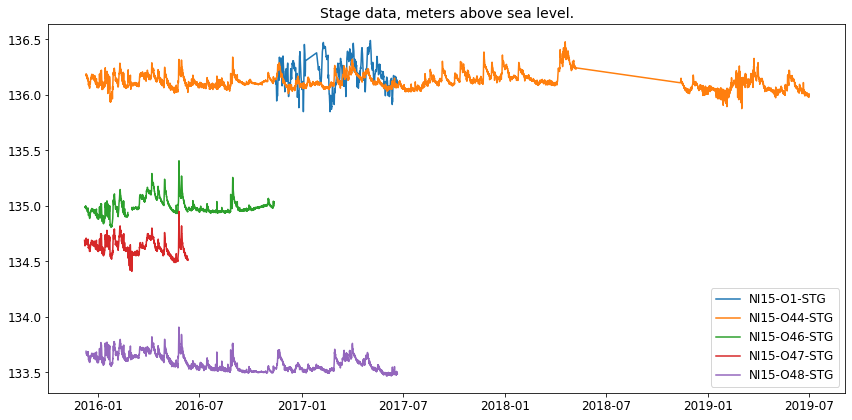

In [9]:
plt.figure(figsize=(12, 6))
for site in df['site'].unique():
    x = df.loc[df['site'] == site]['datetime']
    y = df.loc[df['site'] == site]['stage']
    plt.plot(x, y, label=site)
plt.legend()
plt.title('Stage data, meters above sea level.', fontsize=14)
plt.tight_layout()

### Resample stage data
Resample the data into daily average values:

In [10]:
stage_data_resamp = {}

In [11]:
for site, dataframe in stage_data.items():
    stage_data_resamp[site] = dataframe.resample('d', on='datetime').mean().dropna(how='all')

In [12]:
print('Data points after resampling to daily averages...')
for key,value in stage_data_resamp.items():
    print(f'No. rows in {key}: {len(value)}')

Data points after resampling to daily averages...
No. rows in NI15-O1-STG: 196
No. rows in NI15-O44-STG: 1111
No. rows in NI15-O46-STG: 334
No. rows in NI15-O47-STG: 186
No. rows in NI15-O48-STG: 557


In [13]:
df_resampled = pd.concat(stage_data_resamp).reset_index()
df_resampled.rename(columns={'level_0': 'site'}, inplace=True) # Rename the column

### Visualize both raw and processed data
Lines in color show raw data. Black lines show daily average data. It is the daily average data that will be used as input for OLPROC, as well as for comparison with head data for each individual site.

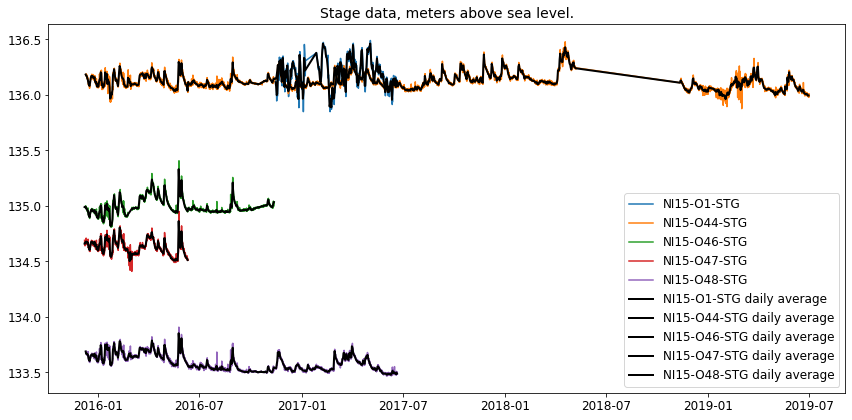

In [14]:
plt.figure(figsize=(12, 6))
for site in df['site'].unique():
    x = df.loc[df['site'] == site]['datetime']
    y = df.loc[df['site'] == site]['stage']
    plt.plot(x, y, label=site)
for site in df_resampled['site'].unique():
    x = df_resampled.loc[df_resampled['site'] == site]['datetime']
    y = df_resampled.loc[df_resampled['site'] == site]['stage']
    plt.plot(x, y, label=f'{site} daily average', color='black', linewidth=2)
plt.legend()
plt.title('Stage data, meters above sea level.', fontsize=14)
plt.tight_layout()

## Prepare datasets for OLPROC

OLPROC reads site sample files (ssf/smp), which is long format data. The following section describes the exportation of the resampled dataset to a site sample file using `pyemu.utils.smp_utils.dataframe_to_smp`

In [15]:
output_dir = os.path.join('..', '..', 'data', 'olproc_input')

Perhaps a redundant step, but for brevities sake let's change the clock hour for each `datetime` entry from `00:00:00` to `12:00:00`, to better reflect that data represent daily average stage:

In [16]:
df_resampled['datetime'] = [i.replace(hour=12) for i in df_resampled['datetime']]

In [17]:
df_resampled.site = df_resampled.site.str.lower()

In [18]:
display(df_resampled)

,site,datetime,stage
0,ni15-o1-stg,2016-11-15 12:00:00,136.114333
1,ni15-o1-stg,2016-11-16 12:00:00,136.076667
2,ni15-o1-stg,2016-11-17 12:00:00,135.997817
3,ni15-o1-stg,2016-11-18 12:00:00,136.011567
4,ni15-o1-stg,2016-11-19 12:00:00,136.161467
...,...,...,...
2379,ni15-o48-stg,2017-06-17 12:00:00,133.494229
2380,ni15-o48-stg,2017-06-18 12:00:00,133.489716
2381,ni15-o48-stg,2017-06-19 12:00:00,133.484119
2382,ni15-o48-stg,2017-06-20 12:00:00,133.498522


Use `pyemu.utils.smp_utils.dataframe_to_smp` to create a site sample file:

In [19]:
pyemu.utils.smp_utils.dataframe_to_smp(
    df_resampled,
    os.path.join(output_dir, 'obs-stage.ssf'),
    name_col='site',
    datetime_col='datetime',
    value_col='stage',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

Done.